- Use Celerite2
- Pulsation + noise
- Sho kernel(s)
- Predefined gap timestamps
- Multiple gap sizes

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Use Celerite v2
import celerite2
from celerite2 import terms

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilCelerite()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("./data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [5]:
# 11300 is the complete first envelope
N_part=11300

In [6]:
X_part=X[:N_part]
Y_part=Y[:N_part]

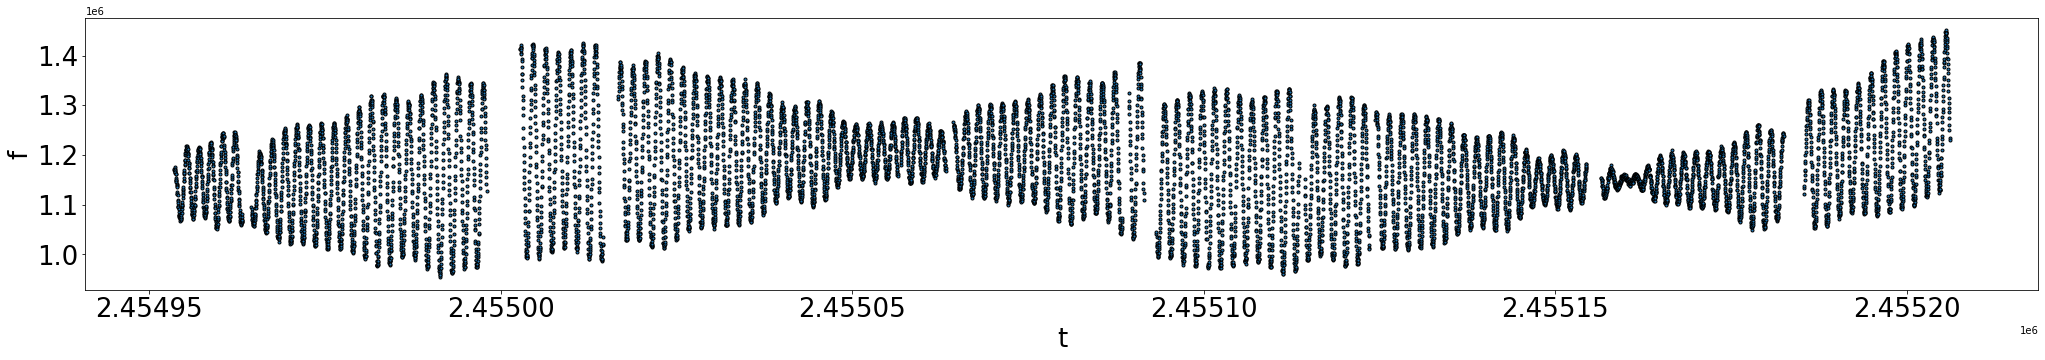

In [7]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [8]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

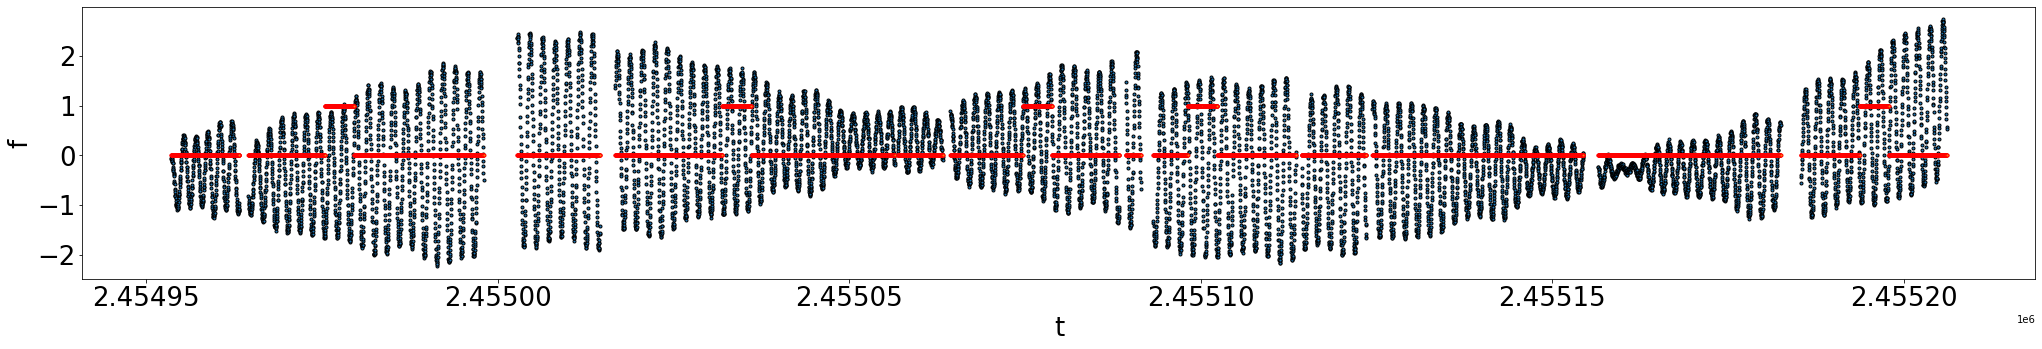

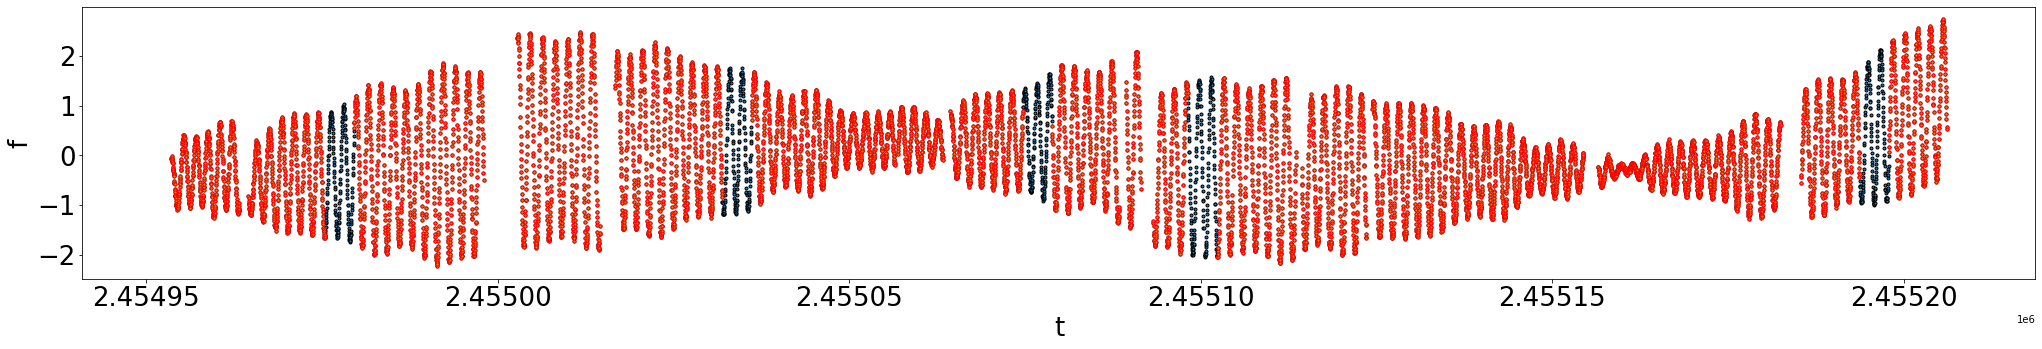

In [9]:
# Introduce gaps in the data
gap_idcs = [1100, 3500, 5500, 6500, 10800]
gap_size = 200

# Define the masks where will introduce the gaps
Y_mask = np.zeros(X_part.shape)
for idx in gap_idcs:
    Y_mask[int(idx-gap_size/2):int(idx+gap_size/2)] = 1

# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

In [20]:
# Initialize the Celerite model
# SHO kernel with the same arguments as for S+Leaf
kernel = terms.SHOTerm(sigma=0.04314, w0=1.7474, Q=8019.36505) +\
         terms.SHOTerm(sigma=0.04314, w0=1.0, Q=8019.36505)

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(X_without_gaps, yerr=0)

print("Initial log likelihood: {0}".format(gp.log_likelihood(Y_without_gaps)))

Initial log likelihood: -2469663102473.3843


In [11]:
from scipy.optimize import minimize

yerr=1

def set_params(params, gp, t):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(sigma=theta[0], w0=theta[1], Q=theta[2]) + \
                terms.SHOTerm(sigma=theta[3], w0=theta[4], Q=theta[5])

    gp.compute(t, diag=yerr ** 2 + theta[6], quiet=True)
    return gp

def neg_log_like(params, gp, t, y):
    gp = set_params(params, gp, t)
    return -gp.log_likelihood(y)

# [mean, sigma1, w1, Q1, sigma2, w2, Q2]
# Q2=0.25
initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, 0.0, np.log(10.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp, X_without_gaps, Y_without_gaps))
gp = set_params(soln.x, gp, X_without_gaps)
soln

      fun: 10122.00546892421
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.1711669 , 0.01982698, 0.95606084, 0.75087883, 0.01982698,
       0.95606084, 0.75087883, 0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 603
      nit: 37
     njev: 67
   status: 0
  success: True
        x: array([-1.23103097e-02, -3.38717457e-01,  1.25661671e+00,  3.06950698e+00,
       -3.38717457e-01,  1.25661671e+00,  3.06950698e+00, -2.09237281e+01])

In [15]:
# We now use Celerite to predict the missing data on the training data scope
Y_pred_gaps, var_pred_gaps = gp.predict(Y_without_gaps, t=X_part, return_var=True)

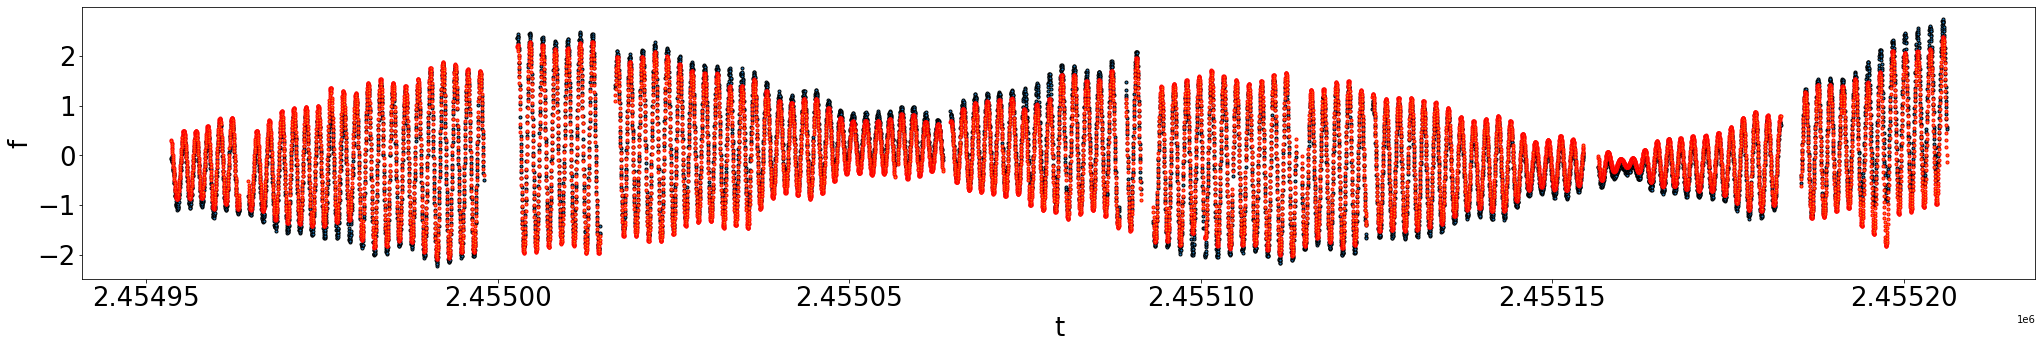

In [16]:
plotter.plot_data(X_part, Y_part, X_part, Y_pred_gaps)

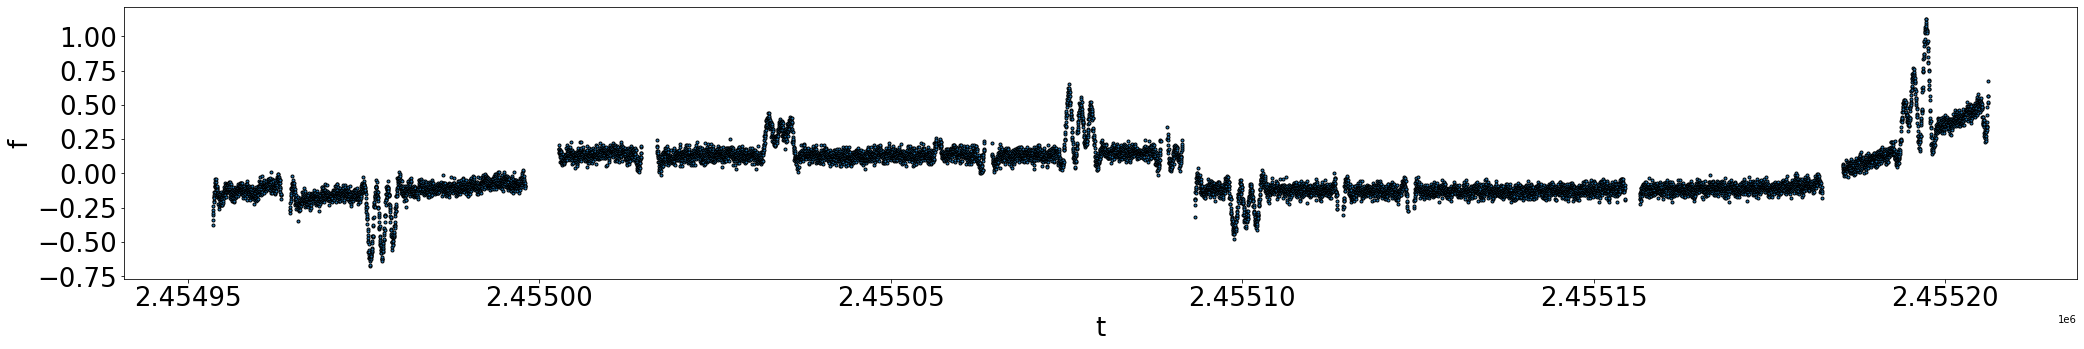

In [17]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_pred_gaps
plotter.plot_data(X_part, residuals)

# Correlation between the original data and the fitted data

In [18]:
experiment_util.calculate_error(Y_part, Y_pred_gaps)

TimeSeriesSimilarity(correlation=0.9823845514768053, rmse=0.18921114903323416)